# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss

%matplotlib inline

In [2]:
from utils.data_gen import compute_bayes_risk_binary, compute_bayes_risk_binary_label_shift,\
    generate_2d_example

from utils.concentrations import hoeffding_ci_lower_limit,\
    hoeffding_ci_upper_limit
from utils.concentrations import pm_bernstein_ci_upper_limit,\
    pm_bernstein_ci_lower_limit

from utils.concentrations import pm_bernstein_lower_limit, pm_bernstein_upper_limit
from utils.concentrations import pm_hoeffding_upper_limit, pm_hoeffding_lower_limit

from utils.data_gen import LDA_predictor

from utils.concentrations import betting_ci_lower_limit, betting_ci_upper_limit

from utils.tests import Drop_tester

In [3]:
sns.set(
    style="whitegrid",
    font_scale=1.4,
    rc={
        "lines.linewidth": 2,
        #             "axes.facecolor": ".9",
        'figure.figsize': (12, 6)
    })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [4]:
legend_dict = ['$\{0\}$', '$\{1\}$']
clr1 = np.array([193, 142, 206]) / 256
clr2 = np.array([125, 225, 125]) / 256
colors = [clr1, clr2]

color1 = np.array([244, 236, 118]) / 256
color2 = np.array([110, 200, 235]) / 256
color3 = np.array([233, 113, 183]) / 256

In [5]:
%load_ext autoreload
%autoreload 2

# Estimate number of samples to reject

In [7]:
num_of_repeats = 250
num_of_batches_to_sample = 40

size_of_batch = 50
size_source_sample = 1000

In [8]:
eps_tol = 0.1

In [9]:
target_cand_probs = np.linspace(0.1,0.9,20)

In [10]:
mu_1 = np.array([1, 0])
mu_0 = np.array([-1, 0])
prob_class_1 = 0.25
prob_class_0 = 1 - prob_class_1
cov = np.eye(2)

In [11]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = prob_class_0
clf.class_1_prior = prob_class_1

clf.predict_both_classes = True

In [12]:
tester_hoeffding = Drop_tester()
tester_bernstein = Drop_tester()
tester_betting = Drop_tester()

tester_hoeffding.eps_tol = eps_tol
tester_bernstein.source_conc_type = 'hoeffding'
tester_hoeffding.target_conc_type = 'pm_hoeffding'
tester_hoeffding.change_type = 'relative'

tester_bernstein.eps_tol = eps_tol
tester_bernstein.source_conc_type = 'pm_bernstein'
tester_bernstein.target_conc_type = 'pm_bernstein'
tester_bernstein.change_type = 'relative'

tester_betting.eps_tol = eps_tol
tester_betting.source_conc_type = 'betting'
tester_betting.target_conc_type = 'betting'
tester_betting.change_type = 'relative'

In [13]:
bern_num_rejects = list()
hoef_num_rejects = list()
bet_num_rejects = list()

bern_num_samples_to_reject = list()
hoef_num_samples_to_reject = list()
bet_num_samples_to_reject = list()

In [14]:
from utils.tests import brier_scores

In [15]:
for cur_ind, cur_target_prob in enumerate(target_cand_probs):

    bern_num_samples_to_reject += [[]]
    hoef_num_samples_to_reject += [[]]
    bet_num_samples_to_reject += [[]]

    bern_num_rejects += [0]
    hoef_num_rejects += [0]
    bet_num_rejects += [0]

    for cur_sim in range(num_of_repeats):

        X_val_source, y_val_source = generate_2d_example(
            0.25, mu_0, mu_1, size_source_sample)

        y_pred_val = clf.predict_proba(X_val_source)
        ind_loss_source = brier_scores(y_val_source,y_pred_val)

        tester_hoeffding.estimate_risk_source(ind_loss_source)
        tester_bernstein.estimate_risk_source(ind_loss_source)
        tester_betting.estimate_risk_source(ind_loss_source)

        X_new_target, y_new_target = generate_2d_example(
            cur_target_prob, mu_0, mu_1,
            size_of_batch * num_of_batches_to_sample)

        y_pred_target = clf.predict_proba(X_new_target)
        ind_loss_target = brier_scores(y_new_target, y_pred_target)

        for cur_batch in range(num_of_batches_to_sample):
            cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
            tester_hoeffding.estimate_risk_target(cur_losses)
            
            if tester_hoeffding.test_for_drop():
                hoef_num_rejects[cur_ind] += 1
                hoef_num_samples_to_reject[cur_ind] += [tester_hoeffding.target_num_of_samples_used]
                break
             
        for cur_batch in range(num_of_batches_to_sample):
            cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
            tester_bernstein.estimate_risk_target(cur_losses)
            
            if tester_bernstein.test_for_drop():
                bern_num_rejects[cur_ind] += 1
                bern_num_samples_to_reject[cur_ind] += [tester_bernstein.target_num_of_samples_used]
                break
                
        for cur_batch in range(num_of_batches_to_sample):
            cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
            tester_betting.estimate_risk_target(cur_losses)
            
            if tester_betting.test_for_drop():
                bet_num_rejects[cur_ind] += 1
                bet_num_samples_to_reject[cur_ind] += [tester_betting.target_num_of_samples_used]
                break

In [16]:
hoef_fraction_rejected = [num_rej / num_of_repeats for num_rej in hoef_num_rejects]
bern_fraction_rejected = [num_rej / num_of_repeats for num_rej in bern_num_rejects]
bet_fraction_rejected = [num_rej / num_of_repeats for num_rej in bet_num_rejects]

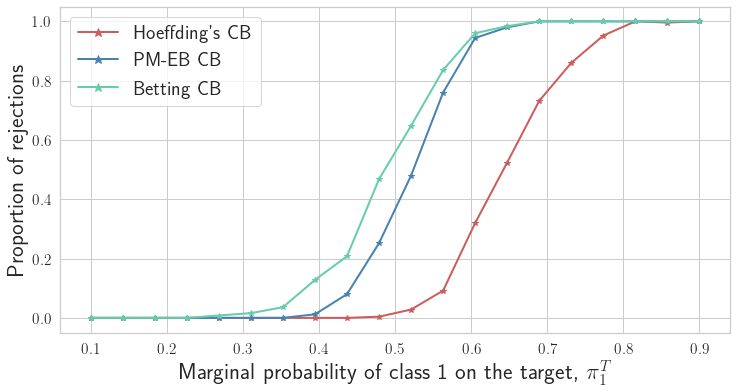

In [17]:
# plt.plot(target_cand_probs, hoef_fraction_rejected, marker='*', label = 'Hoeffding')
# plt.plot(target_cand_probs, bern_fraction_rejected,  marker='*',label = 'Bernstein')
# plt.plot(target_cand_probs, bet_fraction_rejected,  marker='*',label = 'Betting')
# plt.legend(loc=2, markerscale=1.5, prop={'size': 20})
# plt.ylabel('Proportion of rejected', fontsize=25)
# plt.xlabel('Class 1 probability', fontsize=25)
# plt.savefig('img/prop_rej_sim_brier.pdf', bbox_inches='tight')

plt.plot(target_cand_probs,
         hoef_fraction_rejected,
         marker='*',
         label='Hoeffding\'s CB',
         color='indianred')
plt.plot(target_cand_probs,
         bern_fraction_rejected,
         marker='*',
         label='PM-EB CB',
         color='steelblue')
plt.plot(target_cand_probs,
         bet_fraction_rejected,
         marker='*',
         label='Betting CB',
         color='mediumaquamarine')
legend = plt.legend(loc=2, markerscale=1.5, prop={'size': 20})
legend.get_title().set_fontsize('22')
plt.ylabel('Proportion of rejections', fontsize=23)
plt.xlabel('Marginal probability of class 1 on the target, $\pi_1^T$', fontsize=23)
plt.savefig('img/prop_rej_sim_brier.pdf', bbox_inches='tight')

## number of samples

In [18]:
hoef_lengths = np.array([len(cur_prob) for cur_prob in hoef_num_samples_to_reject])
bern_lengths = np.array([len(cur_prob) for cur_prob in bern_num_samples_to_reject])
bet_lengths = np.array([len(cur_prob) for cur_prob in bet_num_samples_to_reject])

In [20]:
min_num_rej=5

In [21]:
hoef_len_ind= (np.array(hoef_lengths)>=min_num_rej).astype('bool')
bern_len_ind = (np.array(bern_lengths)>=min_num_rej).astype('bool')
bet_len_ind = (np.array(bet_lengths)>=min_num_rej).astype('bool')

In [22]:
hoef_avg = np.array([
    np.mean(cur_prob)
    for cur_ind, cur_prob in enumerate(hoef_num_samples_to_reject)
    if hoef_lengths[cur_ind] >= min_num_rej
])

bern_avg = np.array([
    np.mean(cur_prob)
    for cur_ind, cur_prob in enumerate(bern_num_samples_to_reject)
    if bern_lengths[cur_ind] >= min_num_rej
])

bet_avg = np.array([
    np.mean(cur_prob)
    for cur_ind, cur_prob in enumerate(bet_num_samples_to_reject)
    if bet_lengths[cur_ind] >= min_num_rej
])

hoef_stds = np.array([
    np.std(cur_prob)
    for cur_ind, cur_prob in enumerate(hoef_num_samples_to_reject)
    if hoef_lengths[cur_ind] >= min_num_rej
])

bern_stds = np.array([
    np.std(cur_prob)
    for cur_ind, cur_prob in enumerate(bern_num_samples_to_reject)
    if bern_lengths[cur_ind] >= min_num_rej
])

bet_stds = np.array([
    np.std(cur_prob)
    for cur_ind, cur_prob in enumerate(bet_num_samples_to_reject)
    if bet_lengths[cur_ind] >= min_num_rej
])

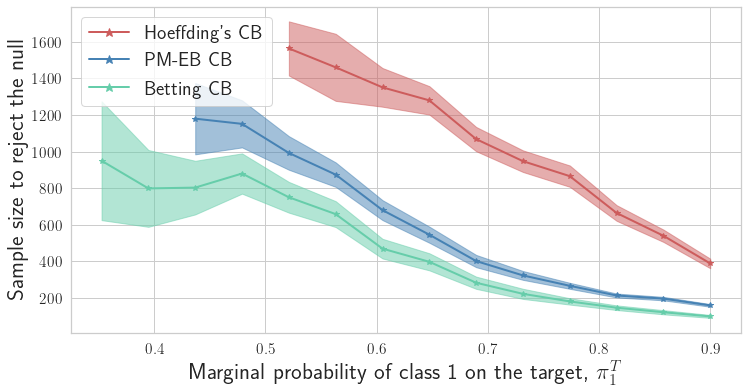

In [23]:
plt.plot(target_cand_probs[hoef_len_ind],
         hoef_avg,
         marker='*',
         label='Hoeffding\'s CB',
         color='indianred')

plt.fill_between(
    target_cand_probs[hoef_len_ind],
    y1=hoef_avg - 2 * hoef_stds / np.sqrt(hoef_lengths[hoef_len_ind]),
    y2=hoef_avg + 2 * hoef_stds / np.sqrt(hoef_lengths[hoef_len_ind]),
    alpha=0.5,
    color='indianred')

plt.plot(target_cand_probs[bern_len_ind],
         bern_avg,
         marker='*',
         label='PM-EB CB',
         color='steelblue')

plt.fill_between(
    target_cand_probs[bern_len_ind],
    y1=bern_avg - 2 * bern_stds / np.sqrt(bern_lengths[bern_len_ind]),
    y2=bern_avg + 2 * bern_stds / np.sqrt(bern_lengths[bern_len_ind]),
    alpha=0.5,
    color='steelblue')

plt.plot(target_cand_probs[bet_len_ind],
         bet_avg,
         marker='*',
         label='Betting CB',
         color='mediumaquamarine')

plt.fill_between(target_cand_probs[bet_len_ind],
                 y1=bet_avg - 2 * bet_stds / np.sqrt(bet_lengths[bet_len_ind]),
                 y2=bet_avg + 2 * bet_stds / np.sqrt(bet_lengths[bet_len_ind]),
                 alpha=0.5,
                 color='mediumaquamarine')

plt.legend(loc=2, markerscale=1.5, prop={'size': 20})
plt.ylabel('Sample size to reject the null', fontsize=23)
plt.xlabel('Marginal probability of class 1 on the target, $\pi_1^T$', fontsize=23)
# plt.axvline(x=target_prob_class_1[np.argmin(nulls == True)],
#             c='goldenrod',
#             linestyle='dashed')
plt.savefig('img/number_of_samples_brier.pdf', bbox_inches='tight')